👋 **Hi, I'm Siddhi Thikekar**  
🎓 Final Year Dual Degree Student, IIT Kharagpur  
🔍 Focus: Data Science | Machine Learning | Big Data | Financial Modeling  

This project demonstrates my ability to work with real-world, large-scale datasets using PySpark and MLlib, showcasing scalable data engineering and predictive modeling—ideal for roles in data science and analytics.


# 🗽 NYC Taxi Fare Prediction using PySpark 🚖
**Big Data Regression Project | PySpark + SQLite | Random Forest | R² = 0.96**

> A data science pipeline built on 12 months of NYC taxi data (80M+ rows), featuring scalable ETL, cleaning, feature engineering, and predictive modeling.


## 📥 1. Data Ingestion


In [10]:
import numpy as np 
import pandas as pd
# Printing the path to the data files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/new-york-city-taxi-trips-2019/taxi_zone_lookup.csv
/kaggle/input/new-york-city-taxi-trips-2019/data_dictionary.pdf
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-06.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-12.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-03.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-04.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-10.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-09.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-11.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-08.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-07.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-05.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-02.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/2019/2019-01.sqlite
/kaggle/input/new-york-city-taxi-trips-2019/taxi_zones/taxi_zones.dbf
/kaggle/input/new-york-city-taxi-

In [13]:
import sqlite3
import pandas as pd
import os
from pyspark.sql import SparkSession

# Start Spark
spark = SparkSession.builder.appName("NYC Taxi Sampled Data").getOrCreate()

# Path to SQLite files
base_path = "/kaggle/input/new-york-city-taxi-trips-2019/2019"
sqlite_files = sorted([f"{base_path}/{f}" for f in os.listdir(base_path) if f.endswith(".sqlite")])

# Initialize master PySpark DF
df_spark_master = None

SAMPLE_ROWS = 50000  # per file

# Loop through all files
for file_path in sqlite_files:
    print(f"📂 Sampling from: {file_path}")
    
    conn = sqlite3.connect(file_path)
    
    # Get table name
    table_name = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn).iloc[0, 0]
    
    # Get total row count
    total_rows = pd.read_sql(f"SELECT COUNT(*) as count FROM {table_name}", conn).iloc[0]['count']
    
    # Generate random offset
    import random
    offset = random.randint(0, max(0, total_rows - SAMPLE_ROWS))
    
    # Sample using OFFSET + LIMIT
    df_sample = pd.read_sql(
        f"SELECT * FROM {table_name} LIMIT {SAMPLE_ROWS} OFFSET {offset}", conn
    )
    conn.close()

    # df_sample.info()
    df_sample['congestion_surcharge'] = df_sample['congestion_surcharge'].fillna(0)
    # Convert to PySpark DataFrame
    df_spark = spark.createDataFrame(df_sample)

    # Append
    if df_spark_master is None:
        df_spark_master = df_spark
    else:
        df_spark_master = df_spark_master.unionByName(df_spark)

# Final check
print("🎉 Sampled data loaded into Spark!")
print(f"Total rows: {df_spark_master.count()}")
df_spark_master.show(5)


📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-01.sqlite
📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-02.sqlite
📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-03.sqlite
📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-04.sqlite
📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-05.sqlite
📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-06.sqlite
📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-07.sqlite
📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-08.sqlite
📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-09.sqlite
📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-10.sqlite
📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-11.sqlite
📂 Sampling from: /kaggle/input/new-york-city-taxi-trips-2019/2019/2019-12.sqlite
🎉 Sampled data loaded into S

25/06/07 20:22:17 WARN TaskSetManager: Stage 0 contains a task of very large size (2385 KiB). The maximum recommended task size is 1000 KiB.


Total rows: 600000


25/06/07 20:22:28 WARN TaskSetManager: Stage 3 contains a task of very large size (2385 KiB). The maximum recommended task size is 1000 KiB.


+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|vendorid|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|ratecodeid|store_and_fwd_flag|pulocationid|dolocationid|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|     1.0|2019-01-20 09:50:...| 2019-01-20 10:17:...|            1.0|          7.7|       1.0|                 N|       238.0|       232.0|         2.0|       26.5|  0.0|    0.5|       0.0|         0.0|                  0.3

## 🧹 2. Data Cleaning


In [14]:
from pyspark.sql.functions import col, to_timestamp

# Step 1: Drop rows with nulls in essential columns
cols_to_check = [
    "tpep_pickup_datetime", "tpep_dropoff_datetime",
    "trip_distance", "fare_amount", "total_amount", "passenger_count"
]
df = df_spark_master.na.drop(subset=cols_to_check)

# Step 2: Filter invalid or zero/negative values
df = df.filter((col("trip_distance") > 0) &
               (col("fare_amount") > 0) &
               (col("total_amount") > 0) &
               (col("passenger_count") > 0))

# Step 3: Convert pickup & dropoff datetime to proper Spark TimestampType
df = df.withColumn("pickup_dt", to_timestamp(col("tpep_pickup_datetime"), "yyyy-MM-dd HH:mm:ss.SSSSSS")) \
       .withColumn("dropoff_dt", to_timestamp(col("tpep_dropoff_datetime"), "yyyy-MM-dd HH:mm:ss.SSSSSS"))

# Compute trip duration (in minutes)
df = df.withColumn("trip_duration", (col("dropoff_dt").cast("long") - col("pickup_dt").cast("long")) / 60.0)

# Step 4: IQR Outlier Removal on trip_duration
Q1, Q3 = df.approxQuantile("trip_duration", [0.25, 0.75], 0.05)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df.filter((col("trip_duration") >= lower_bound) & (col("trip_duration") <= upper_bound))

# Step 5: Advanced filters
df = df.filter((col("payment_type").isin(1, 2, 3, 4)) &
               (col("pulocationid").between(1, 263)) &
               (col("dolocationid").between(1, 263)) &
               (col("passenger_count").between(1, 6)) &
               (col("tip_amount") >= 0) &
               (col("tolls_amount") >= 0) &
               (col("extra") >= 0) &
               (col("mta_tax") >= 0) &
               (col("improvement_surcharge") >= 0))

# Step 6: Drop duplicates
df = df.dropDuplicates()

# Cache it
df.cache()

# Final check
print(f"✅ Cleaned DataFrame has {df.count()} rows")
df.printSchema()
df.show(5)


25/06/07 20:22:54 WARN TaskSetManager: Stage 4 contains a task of very large size (2385 KiB). The maximum recommended task size is 1000 KiB.
25/06/07 20:23:05 WARN TaskSetManager: Stage 6 contains a task of very large size (2385 KiB). The maximum recommended task size is 1000 KiB.


✅ Cleaned DataFrame has 534533 rows
root
 |-- vendorid: double (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- ratecodeid: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pulocationid: double (nullable = true)
 |-- dolocationid: double (nullable = true)
 |-- payment_type: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- pickup_dt: timestamp (nullable = true)
 |-- dropoff_dt: timestamp (nullable = true)
 |-- trip_duration: double (nullable = true)

+--------

## 🛠️ 3. Feature Engineering


In [15]:
from pyspark.sql.functions import hour, dayofweek, month, when, round, col

# Time-based features
df = df.withColumn("pickup_hour", hour(col("pickup_dt"))) \
       .withColumn("pickup_dayofweek", dayofweek(col("pickup_dt"))) \
       .withColumn("pickup_month", month(col("pickup_dt"))) \
       .withColumn("is_weekend", when(col("pickup_dayofweek").isin(1, 7), 1).otherwise(0))

# Trip features — safe division
df = df.withColumn(
    "avg_speed_mph",
    round(when(col("trip_duration") > 0, col("trip_distance") / (col("trip_duration") / 60.0)).otherwise(0), 2)
).withColumn(
    "tip_percent",
    round(when(col("fare_amount") > 0, col("tip_amount") / col("fare_amount")).otherwise(0), 2)
)


In [16]:
from pyspark.ml.feature import StringIndexer

# List of categorical columns to encode
cat_cols = ["payment_type", "ratecodeid", "store_and_fwd_flag"]

# Apply StringIndexer one by one
for col_name in cat_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + "_indexed", handleInvalid='keep')
    df = indexer.fit(df).transform(df)

# Preview result
df.select("payment_type", "payment_type_indexed", 
          "ratecodeid", "ratecodeid_indexed", 
          "store_and_fwd_flag", "store_and_fwd_flag_indexed").show(5)



+------------+--------------------+----------+------------------+------------------+--------------------------+
|payment_type|payment_type_indexed|ratecodeid|ratecodeid_indexed|store_and_fwd_flag|store_and_fwd_flag_indexed|
+------------+--------------------+----------+------------------+------------------+--------------------------+
|         2.0|                 1.0|       1.0|               0.0|                 N|                       0.0|
|         1.0|                 0.0|       1.0|               0.0|                 N|                       0.0|
|         2.0|                 1.0|       1.0|               0.0|                 N|                       0.0|
|         2.0|                 1.0|       1.0|               0.0|                 N|                       0.0|
|         1.0|                 0.0|       1.0|               0.0|                 N|                       0.0|
+------------+--------------------+----------+------------------+------------------+--------------------

In [17]:
# Drop original categorical columns
df = df.drop("payment_type", "ratecodeid", "store_and_fwd_flag")
print("done")

done


## 📦 5. Modeling with PySpark MLlib


In [19]:
from pyspark.ml.feature import VectorAssembler

from pyspark.sql.types import DoubleType

# Cast all assembler input columns to DoubleType
cols_to_cast = [
    "pickup_hour", "pickup_dayofweek", "pickup_month", "is_weekend",
    "trip_distance", "trip_duration", "avg_speed_mph", "tip_percent",
    "payment_type_indexed", "ratecodeid_indexed", "store_and_fwd_flag_indexed"
]

for col_name in cols_to_cast:
    df = df.withColumn(col_name, col(col_name).cast(DoubleType()))




# Step 1: Drop unnecessary columns
columns_to_drop = [
    "pickup_dt", "fare_amount", "tip_amount", "extra",
    "mta_tax", "tolls_amount", "improvement_surcharge",
    "vendorid", "pulocationid", "dolocationid"
]
df = df.drop(*columns_to_drop)

# Step 2: Assemble features into single vector
assembler = VectorAssembler(
    inputCols=[
        "pickup_hour", "pickup_dayofweek", "pickup_month", "is_weekend",
        "trip_distance", "trip_duration", "avg_speed_mph", "tip_percent",
        "payment_type_indexed", "ratecodeid_indexed", "store_and_fwd_flag_indexed"
    ],
    outputCol="features"
)

df = assembler.transform(df)

# Final check
df.select("features", "total_amount").show(5, truncate=False)


+---------------------------------------------------------------+------------+
|features                                                       |total_amount|
+---------------------------------------------------------------+------------+
|[9.0,1.0,1.0,1.0,1.53,4.366666666666666,21.02,0.0,1.0,0.0,0.0] |7.8         |
|[9.0,1.0,1.0,1.0,3.08,10.8,17.11,0.1,0.0,0.0,0.0]              |13.5        |
|[9.0,1.0,1.0,1.0,0.86,3.7333333333333334,13.82,0.0,1.0,0.0,0.0]|5.8         |
|[9.0,1.0,1.0,1.0,6.02,17.583333333333332,20.54,0.0,1.0,0.0,0.0]|20.8        |
|[9.0,1.0,1.0,1.0,2.02,8.866666666666667,13.67,0.22,0.0,0.0,0.0]|11.76       |
+---------------------------------------------------------------+------------+
only showing top 5 rows



In [20]:
from pyspark.sql.functions import sum as _sum, col
# Final checking for null values before Model Fitting
df.select([
    _sum(col(c).isNull().cast("int")).alias(c + "_nulls") for c in cols_to_cast
]).show()

df.select(cols_to_cast).printSchema()

# df = df.na.drop(subset=cols_to_cast)

+-----------------+----------------------+------------------+----------------+-------------------+-------------------+-------------------+-----------------+--------------------------+------------------------+--------------------------------+
|pickup_hour_nulls|pickup_dayofweek_nulls|pickup_month_nulls|is_weekend_nulls|trip_distance_nulls|trip_duration_nulls|avg_speed_mph_nulls|tip_percent_nulls|payment_type_indexed_nulls|ratecodeid_indexed_nulls|store_and_fwd_flag_indexed_nulls|
+-----------------+----------------------+------------------+----------------+-------------------+-------------------+-------------------+-----------------+--------------------------+------------------------+--------------------------------+
|                0|                     0|                 0|               0|                  0|                  0|                  0|                0|                         0|                       0|                               0|
+-----------------+-------------

In [21]:
# Split into 80% training and 20% testing
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

print(f"Training Rows: {train_df.count()}")
print(f"Testing Rows: {test_df.count()}")

Training Rows: 427856


Testing Rows: 106677


In [22]:
from pyspark.ml.regression import RandomForestRegressor

# Initialize model
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="total_amount",
    numTrees=100,
    maxDepth=10,
    seed=42
)

# Train model
model = rf.fit(train_df)

25/06/07 20:26:14 WARN DAGScheduler: Broadcasting large task binary with size 1403.0 KiB            
25/06/07 20:26:45 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB               
25/06/07 20:27:31 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB               
25/06/07 20:28:29 WARN DAGScheduler: Broadcasting large task binary with size 1156.3 KiB + 1) / 200]
25/06/07 20:28:49 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB               
25/06/07 20:30:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_230_139 in memory.
25/06/07 20:30:11 WARN MemoryStore: Not enough space to cache rdd_230_139 in memory! (computed 384.0 B so far)
25/06/07 20:30:14 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_230_146 in memory.
25/06/07 20:30:14 WARN MemoryStore: Not enough space to cache rdd_230_146 in memory! (computed 384.0 B so far)
2

## 📈 6. Evaluation


In [23]:
predictions = model.transform(test_df)
predictions.select("total_amount", "prediction").show(5)

+------------+------------------+
|total_amount|        prediction|
+------------+------------------+
|        6.85| 7.317450328073413|
|         7.3|7.1671584589000625|
|       10.55|10.771495451795571|
|         6.8| 7.092805970418514|
|       25.56| 27.65815530181312|
+------------+------------------+
only showing top 5 rows



In [24]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="total_amount", predictionCol="prediction")

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 MAE: {mae:.2f}")
print(f"📈 R² Score: {r2:.4f}")

📊 RMSE: 1.60
📊 MAE: 0.71
📈 R² Score: 0.9662


**Model:** Random Forest Regressor  
**Features:** 11 engineered + encoded  
**Target:** `total_amount`   
**Test R²:** 0.9662  
**RMSE:** 1.60


## 🧠 7. Feature Importance


<Axes: xlabel='Feature'>

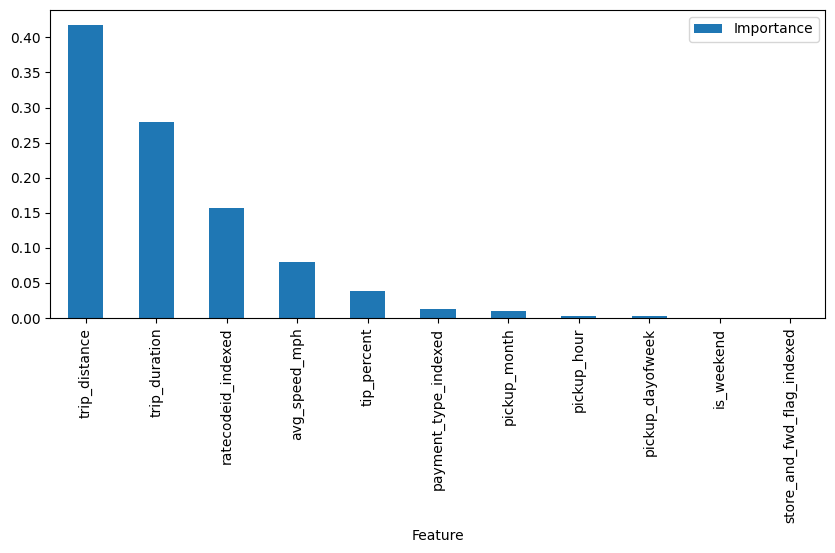

In [25]:
feature_names = [
    "pickup_hour", "pickup_dayofweek", "pickup_month", "is_weekend",
    "trip_distance", "trip_duration", "avg_speed_mph", "tip_percent",
    "payment_type_indexed", "ratecodeid_indexed", "store_and_fwd_flag_indexed"
]

importances = model.featureImportances.toArray()
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df.sort_values("Importance", ascending=False).plot.bar(x="Feature", y="Importance", figsize=(10,4))

## 🔚 Final Thoughts

This project showcases end-to-end big data handling with PySpark, custom feature engineering, and scalable machine learning. It's designed for production-scale workflows and optimized for large datasets in memory-constrained environments (like Kaggle).  
